In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


### Visualize an example

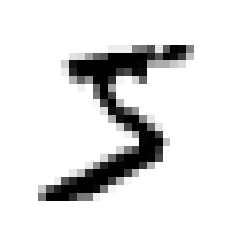

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

### The Example's label

In [8]:
y[0]

'5'

In [10]:
import numpy as np

# cast y to integers
y = y.astype(np.uint8)

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [12]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

#Linear classifiers (SVM, logistic regression, etc.) with SGD training.


sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

#### let’s look at a very dumb classifier that just classifies every single image in the “not-5” class

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

### Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [21]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Equation 3-1. Precision

precision = TP / ( TP + FP )

Equation 3-2. Recall

recall = TP / ( TP + FN )

In [23]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # == 4096 / (4096 + 1522)

print(recall_score(y_train_5, y_train_pred)) # == 4096 / (4096 + 1325)

0.8370879772350012
0.6511713705958311


#### Equation 3-3. F1

F1 = TP / (TP + ( FN + FP) / 2)

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision/Recall Tradeoff


#### Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a  score for each instance

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents
a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 8,000.

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                    method="decision_function")

Now with these scores you can compute precision and recall for all possible thresholds
using the precision_recall_curve() function:

In [30]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

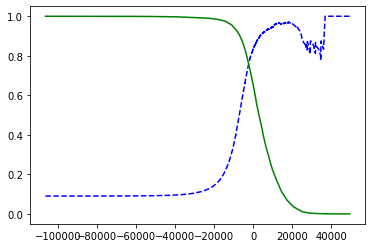

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
        plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
        plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
        [...] # highlight the threshold, add the legend, axis label and grid
        
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# Multiclass Classification

In [48]:
sgd_clf.fit(X_train, y_train) 
sgd_clf.predict([some_digit])

array([0], dtype=uint8)

In [49]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ 14390.59839396, -36919.31719967,  -9811.47434817,
         -8054.56345089, -21825.25725463, -11313.62371972,
        -23649.39025808, -15986.78463914,  -3798.52944589,
        -10635.46503726]])

In [50]:
np.argmax(some_digit_scores)

0

In [51]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
capable of handling multiple classes directly. Others (such as Support Vector Machine
classifiers or Linear classifiers) are strictly binary classifiers. However, there are various
strategies that you can use to perform multiclass classification using multiple
binary classifiers.

when you want to classify an image, you get
the decision score from each classifier for that image and you select the class whose
classifier outputs the highest score. This is called the one-versus-all (OvA) strategy
(also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish
0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. The main advantage
of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use
the OneVsOneClassifier or OneVsRestClassifier classes

In [52]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([0], dtype=uint8)

In [54]:
len(ovo_clf.estimators_)


45

In [57]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([0], dtype=uint8)

In [58]:
forest_clf.predict_proba([some_digit])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

####  Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score() function:

In [59]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [63]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [64]:
X_train_scaled[0].min(), X_train_scaled[0].max()

(-1.122775514498137, 14.967665886649257)

## Error Analysis

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [67]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

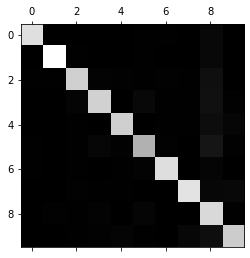

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

the 5s look slightly darker than the
other digits, which could mean that there are fewer images of 5s in the dataset or that
the classifier does not perform as well on 5s as on other digits.

Let’s focus the plot on the errors. First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look
unfairly bad):

In [69]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now let’s fill the diagonal with zeros to keep only the errors

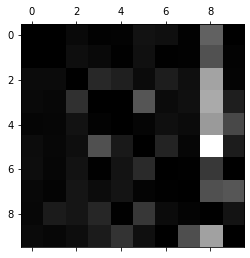

In [71]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()